# COMP5318 - Machine Learning and Data Mining: Assignment 1
<div style="text-align: right"> Due: Wednesday 14 Oct 2020 11:59PM </div>

The goal of this assignment is to build a classifier to classify some grayscale images of the size 28x28 into a set of categories. The dimension of the original data is large, so you need to be smart on which method you gonna use and perhaps perform a pre-processing step to reduce the amount of computation. Part of your marks will be a function of the performance of your classifier on the test set.

In [1]:
import h5py
import numpy as np
import os
print(os.listdir("./Input/train"))

['images_training.h5', 'labels_training.h5']


In [2]:
with h5py.File('./Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])

# using H['datatest'], H['labeltest'] for test dataset.
print(data_train.shape,label_train.shape)

(30000, 784) (30000,)


In [3]:
with h5py.File('./Input/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

# using H['datatest'], H['labeltest'] for test dataset.
print(data_test.shape,label_test.shape)

(5000, 784) (2000,)


Showing a sample data. The first example belongs to class 0: T-Shirt/Top

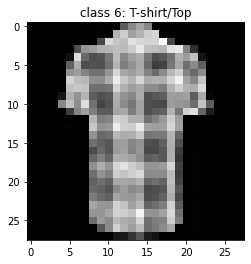

In [4]:
# import matplotlib.pyplot as plt
# data_train = data_train.reshape((data_train.shape[0], 28, 28))
# plt.imshow(data_train[0], cmap=plt.get_cmap('gray'))
# plt.title("class " + str(label_train[0]) + ": T-shirt/Top" )
# plt.show()

In [4]:
# def PCA(n_components, data):
#     """
#     Principal Component Analysis
    
#     Parameters: 
    
#     n_components: int
#         Number of principal components to use
        
#     data : array-like, shape = (n_samples, n_features)
#         Data to perform PCA on
    
#     """
#     n_components = n_components
#     data = data
#     X = data - np.mean(data, axis=0) # data matrix normalized by mean
#     S = np.cov(X.T) # compute covariance matrix of X
#     L, V = np.linalg.eig(S) # L - array of eigenvalues; V - matrix of eigenvectors
#     V = V[:,np.argsort(-L)][:,:n_components] # sort eigenvectors by descending order on eigenvalues
#     L = -np.sort(-L)[:n_components] # sort eigenvalues by descending order
#     X_PCA = V.T @ X.T
#     X_PCA = X_PCA.T
#     return X_PCA

[[9.00722965e-08 6.23442279e-08 6.25785182e-08 ... 8.16134176e-08
  6.76941525e-08 7.31230775e-08]
 [6.23442279e-08 9.69731629e-07 1.17479610e-06 ... 1.22945045e-06
  8.05206791e-07 1.63612200e-07]
 [6.25785182e-08 1.17479610e-06 8.55563928e-06 ... 3.01234442e-06
  6.36201581e-07 9.64931813e-08]
 ...
 [8.16134176e-08 1.22945045e-06 3.01234442e-06 ... 4.64713331e-03
  1.58239151e-03 1.38809052e-04]
 [6.76941525e-08 8.05206791e-07 6.36201581e-07 ... 1.58239151e-03
  1.27599569e-03 1.53939870e-04]
 [7.31230775e-08 1.63612200e-07 9.64931813e-08 ... 1.38809052e-04
  1.53939870e-04 7.46957939e-05]]
[29.12763185419586, 17.703290089309917, 5.988096191731622, 4.930413895189553, 3.8387057626109256, 3.4484275645562232, 2.364401001605165, 1.873416666108097, 1.3419722579545015, 1.3076152066717355, 0.9879083552882953, 0.9108461919258826, 0.7674776078747019, 0.6560324883747961, 0.6079439645798298, 0.5886575228106977, 0.5550105861419041, 0.5333909279765046, 0.4633928047277631, 0.45428619006266135]
[29

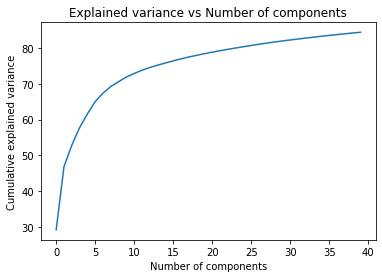

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
#data = np.append(flat(data_train), flat(data_test))
data = np.concatenate([data_train, data_test], axis=0)
covariance_matrix = np.cov(data.T)
print(covariance_matrix)
eig_val, eig_vec = np.linalg.eig(covariance_matrix)

variance_explained = []
for i in eig_val:
    variance_explained.append((i/sum(eig_val))*100)      
print(variance_explained[:20])
cumulative_variance_explained = np.cumsum(variance_explained)
print(cumulative_variance_explained[:20])
sns.lineplot(x = np.arange(40), y=cumulative_variance_explained[:40])
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Explained variance vs Number of components")

projection_matrix = (eig_vec.T[:][:40]).T
X_pca = data.dot(projection_matrix)
X_train_pca = X_pca[:data_train.shape[0]]
X_test_pca = X_pca[-data_test.shape[0]:]
print(X_train_pca.shape)
print(X_test_pca.shape)

In [48]:
merge_arr = np.concatenate([data_train, data_test], axis=0)
merge_arr.shape

(35000, 784)

In [16]:

# n_components = 40
# X_train_pca = PCA(n_components, data_train)
# xtrain_pca.shape
# X_test_pca = PCA(n_components, data_test)

In [64]:
# from sklearn.decomposition import PCA
# n_components = 100
# pca = PCA(n_components=n_components, svd_solver="full")
# #pca.fit(d2_data_train)

# X_train_pca = pca.fit_transform(data_train)
# print(pca.explained_variance_ratio_)
# X_test_pca = pca.fit_transform(data_test)
# print(pca.explained_variance_ratio_)

# #print(pca.singular_values_)
# len(X_train_pca)

[0.29077056 0.17729232 0.06013924 0.04936654 0.03827854 0.034506
 0.02359772 0.01876142 0.01355582 0.01309763 0.00986248 0.00910981
 0.00767653 0.00657987 0.00607504 0.00588979 0.00555804 0.00531097
 0.00461493 0.00456438 0.00430874 0.00405317 0.00385287 0.00371654
 0.00363843 0.0035357  0.0033338  0.00320463 0.00308857 0.00290794
 0.00277894 0.00267885 0.00263312 0.00255214 0.00247383 0.00236587
 0.00230014 0.00225125 0.00219468 0.00211174 0.0020149  0.0019581
 0.00192782 0.00182938 0.00174134 0.00172355 0.00168008 0.00165527
 0.00161192 0.00155493 0.00153694 0.00151135 0.00147363 0.00143209
 0.00137588 0.00136381 0.00131263 0.00128635 0.00127224 0.00125268
 0.00122533 0.00120101 0.00118518 0.00116583 0.00115325 0.00112762
 0.00111305 0.00110361 0.00106089 0.00105437 0.0010317  0.0010083
 0.00098745 0.00096578 0.00094431 0.00093239 0.00092853 0.00090147
 0.00089694 0.0008799  0.00086895 0.00084215 0.00083253 0.00081648
 0.00081039 0.00079961 0.00078464 0.0007718  0.00076433 0.00076186

30000

In [53]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
k = 10 # number of folds for cv
indices_cv = KFold(n_splits=10, random_state=None, shuffle=False) # indices for the k-folds
score_list_PCA = []
n_comp_list = np.arange(8, 15)
for K in n_comp_list:
    knn = KNeighborsClassifier(n_neighbors=K)
    score = 0
    count = 1
    for train_index, test_index in indices_cv.split(X_train_pca):
        print("comp", K, " fold", count)
        count+=1
        test_id = test_index
        train_id = train_index
        y_true = label_train[test_id]
        model = knn.fit(X_train_pca[train_id], label_train[train_id])
        score += model.score(X_train_pca[test_index], label_train[test_id])
    score_list_PCA.append(score/k)
score_list_PCA = np.array(score_list_PCA)


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
n_comp_list = np.arange(8, 15)
ax.plot(n_comp_list, score_list_PCA)
ax.axvline(n_comp_list[np.argmax(score_list_PCA)], c='m', linestyle='--', alpha=0.6)
ax.set_xlabel('# Neighbors')
ax.set_ylabel('Accuracy')
ax.set_xticks(n_comp_list)
ax.set_title('Results after PCA')
plt.show()

In [ ]:
%%time
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

y_true = label_test
knn = KNeighborsClassifier(n_neighbors=np.argmax(score_list_PCA), algorithm="kd_tree")
knn.fit(X_train_pca, label_train)
y_pred = knn.predict(X_test_pca)
print(knn.score(X_test_pca[:2000], label_test))


In [64]:
%%time
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

y_true = label_test
knn = KNeighborsClassifier(n_neighbors=9, algorithm="kd_tree")
knn.fit(X_train_pca, label_train)
y_pred = knn.predict(X_test_pca)
y_true = np.array(y_true)
print(y_true[:10])
y_pred = np.array(y_pred)
print(y_pred[:10])
np.sum(y_true == y_pred[:2000])/len(y_true)

CPU times: user 3.27 s, sys: 57.3 ms, total: 3.33 s
Wall time: 5.28 s


In [65]:
y_true = np.array(y_true)
print(y_true[:10])
y_pred = np.array(y_pred)
print(y_pred[:10])
np.sum(y_true == y_pred[:2000])/len(y_true)

[1 8 1 8 4 0 4 5 3 1]
[1 8 1 8 4 0 6 9 3 1]


0.839

In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
#making the instance
model = KNeighborsClassifier(n_jobs=-1)
#Hyper Parameters Set
params = {'n_neighbors':[8,9,10,11,12],
          'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'n_jobs':[-1]}
#Making models with hyper parameters sets
model1 = GridSearchCV(model, param_grid=params, n_jobs=1, verbose=10)
#Learning
model1.fit(X_train_pca,label_train)
#The best hyper parameters set
print("Best Hyper Parameters:\n",model1.best_params_)
#Prediction
prediction=model1.predict(data_test)
#importing the metrics module
from sklearn import metrics
#evaluation(Accuracy)
print("Accuracy:",metrics.accuracy_score(prediction,label_test))
#evaluation(Confusion Metrix)
print("Confusion Metrix:\n",metrics.confusion_matrix(prediction,label_test))

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV] algorithm=auto, leaf_size=1, n_jobs=-1, n_neighbors=8, weights=uniform 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV]  algorithm=auto, leaf_size=1, n_jobs=-1, n_neighbors=8, weights=uniform, score=0.849, total=   7.2s
[CV] algorithm=auto, leaf_size=1, n_jobs=-1, n_neighbors=8, weights=uniform 
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s
[CV]  algorithm=auto, leaf_size=1, n_jobs=-1, n_neighbors=8, weights=uniform, score=0.844, total=   4.9s
[CV] algorithm=auto, leaf_size=1, n_jobs=-1, n_neighbors=8, weights=uniform 
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s
[CV]  algorithm=auto, leaf_size=1, n_jobs=-1, n_neighbors=8, weights=uniform, score=0.849, total=   5.0s
[CV] algorithm=auto, leaf_size=1, n_jobs=-1, n_neighbors=8, weights=uniform 
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.1s remaining:  

KeyboardInterrupt: 